# 1. Create Spark Session & Import Libraries

In [3]:
# if pyspark needs to be installed:
# !pip install pyspark findspark

     |████████████████████████████████| 317.2 MB 631 bytes/s a 0:00:01
     |████████████████████████████████| 200 kB 14.7 MB/s eta 0:00:01
done
  Created wheel for pyspark: filename=pyspark-3.5.5-py2.py3-none-any.whl size=317747881 sha256=d56628120b90e242e8f289edb3204e1e76b7db3bea46cb313c2720c4293412c2
  Stored in directory: /home/jj/.cache/pip/wheels/9e/5b/b4/a3ac8d456edf8c52eb15f9eb357d961812d5f17bf203c54c18
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.9
    Uninstalling py4j-0.10.9.9:
      Successfully uninstalled py4j-0.10.9.9


In [31]:
# spark libraries
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType, StructType, StructField

# ds libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ml libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

findspark.init()

spark = SparkSession.builder \
    .appName("FlightDelayBatchProcessing") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

25/04/18 23:10:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/04/18 23:10:55 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# 2. Define Schema & Data Preprocessing

In [32]:
# define schema
schema = StructType([
    StructField("FL_DATE", StringType(), True),
    StructField("AIRLINE", StringType(), True),
    StructField("AIRLINE_DOT", StringType(), True),
    StructField("AIRLINE_CODE", StringType(), True),
    StructField("DOT_CODE", IntegerType(), True),
    StructField("FL_NUMBER", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("ORIGIN_CITY", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("DEST_CITY", StringType(), True),
    StructField("CRS_DEP_TIME", IntegerType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", IntegerType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("DELAY_DUE_CARRIER", DoubleType(), True),
    StructField("DELAY_DUE_WEATHER", DoubleType(), True),
    StructField("DELAY_DUE_NAS", DoubleType(), True),
    StructField("DELAY_DUE_SECURITY", DoubleType(), True),
    StructField("DELAY_DUE_LATE_AIRCRAFT", DoubleType(), True)
])

# read in csv data file
data_path = "flight_data.csv"
df = spark.read.csv(data_path, header=True, schema=schema)

# edit formatting of flight date
df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))

### Data Checking

In [33]:
# show df schema
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

In [34]:
# (TO DO): clean up formatting of output
# show 1st 5 rows of df
df.show(5, truncate=False)

+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|FL_DATE   |AIRLINE              |AIRLINE_DOT              |AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|ORIGIN_CITY        |DEST|DEST_CITY            |CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+

### Data Cleaning

In [35]:
columns_to_drop = [
    'AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY',
    'DEP_TIME', 'DEP_DELAY',
    'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
    'ARR_TIME',
    'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
    'ELAPSED_TIME', 'AIR_TIME',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]
df_cleaned = df.drop(*columns_to_drop)


df_cleaned = df_cleaned.dropna(subset=[
    "ARR_DELAY", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
    "DISTANCE", "ORIGIN", "DEST", "AIRLINE", "AIRLINE_CODE"
])

### Data Checking

In [36]:
# show df schema
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

In [37]:
# (TO DO): clean up formatting of output
# show 1st 5 rows of df
df.show(5, truncate=False)

+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|FL_DATE   |AIRLINE              |AIRLINE_DOT              |AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|ORIGIN_CITY        |DEST|DEST_CITY            |CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+

# 3. Feature Engineering

In [38]:
delay_threshold = 45

df_featured = df_cleaned.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= delay_threshold, 1).otherwise(0))
df_featured = df_featured.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("integer"))     # dep hour
df_featured = df_featured.withColumn("DEP_MINUTE", (F.col("CRS_DEP_TIME") % 100).cast("integer"))   # dep minute
df_featured = df_featured.withColumn("ARR_HOUR", (F.col("CRS_ARR_TIME") / 100).cast("integer"))     # arrival hour
df_featured = df_featured.withColumn("ARR_MINUTE", (F.col("CRS_ARR_TIME") % 100).cast("integer"))   # arrival minute
df_featured = df_featured.withColumn("DEP_DAY_OF_WEEK", F.dayofweek(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_MONTH", F.month(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_DAY_OF_MONTH", F.dayofmonth(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_WEEK_OF_YEAR", F.weekofyear(F.col("FL_DATE")))
df_featured = df_featured.withColumn("IS_WEEKEND", F.when(F.col("DEP_DAY_OF_WEEK").isin([1, 7]), 1).otherwise(0))
df_featured = df_featured.withColumn("DISTANCE_PER_MINUTE", F.col("DISTANCE") / (F.col("CRS_ELAPSED_TIME") + 1e-6))

featureCols = [
    "AIRLINE_CODE", "ORIGIN", "DEST",
    "CRS_ELAPSED_TIME", "DISTANCE",
    "DEP_HOUR", "DEP_MINUTE", "ARR_HOUR", "ARR_MINUTE",
    "DEP_DAY_OF_WEEK", "DEP_MONTH", "DEP_DAY_OF_MONTH", "DEP_WEEK_OF_YEAR",
    "IS_WEEKEND", "DISTANCE_PER_MINUTE"
]

labelCol = "SEVERE_DELAY"

final_df = df_featured.select(featureCols + [labelCol, "FL_DATE"])

In [39]:
final_df.printSchema()

root
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DEP_HOUR: integer (nullable = true)
 |-- DEP_MINUTE: integer (nullable = true)
 |-- ARR_HOUR: integer (nullable = true)
 |-- ARR_MINUTE: integer (nullable = true)
 |-- DEP_DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_MONTH: integer (nullable = true)
 |-- DEP_DAY_OF_MONTH: integer (nullable = true)
 |-- DEP_WEEK_OF_YEAR: integer (nullable = true)
 |-- IS_WEEKEND: integer (nullable = false)
 |-- DISTANCE_PER_MINUTE: double (nullable = true)
 |-- SEVERE_DELAY: integer (nullable = false)
 |-- FL_DATE: date (nullable = true)



In [40]:
# (TO DO): clean up formatting of output
final_df.show(5, truncate=False)

+------------+------+----+----------------+--------+--------+----------+--------+----------+---------------+---------+----------------+----------------+----------+-------------------+------------+----------+
|AIRLINE_CODE|ORIGIN|DEST|CRS_ELAPSED_TIME|DISTANCE|DEP_HOUR|DEP_MINUTE|ARR_HOUR|ARR_MINUTE|DEP_DAY_OF_WEEK|DEP_MONTH|DEP_DAY_OF_MONTH|DEP_WEEK_OF_YEAR|IS_WEEKEND|DISTANCE_PER_MINUTE|SEVERE_DELAY|FL_DATE   |
+------------+------+----+----------------+--------+--------+----------+--------+----------+---------------+---------+----------------+----------------+----------+-------------------+------------+----------+
|UA          |FLL   |EWR |186.0           |1065.0  |11      |55        |15      |1         |4              |1        |9               |2               |0         |5.725806420828998  |0           |2019-01-09|
|DL          |MSP   |SEA |235.0           |1399.0  |21      |20        |23      |15        |7              |11       |19              |46              |1         |5.953

# 4. Basic Visualizations

Plotting with 2709 samples.


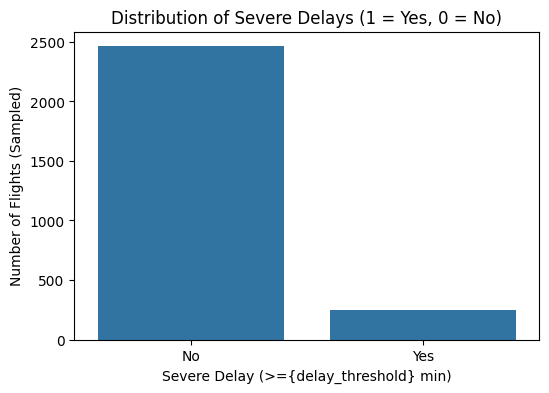

In [41]:
# Doing a sample because it was too large otherwise
plot_sample_df = final_df.sample(withReplacement=False, fraction=0.01, seed=42).toPandas()
print(f"Plotting with {len(plot_sample_df)} samples.")

# 1. Distribution of Severe Delays
plt.figure(figsize=(6, 4))
sns.countplot(x='SEVERE_DELAY', data=plot_sample_df)
plt.title('Distribution of Severe Delays (1 = Yes, 0 = No)')
plt.xlabel('Severe Delay (>={delay_threshold} min)')
plt.ylabel('Number of Flights (Sampled)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [42]:
# Getting imbalance ratio but using the full dataset for accuracy
target_counts = final_df.groupBy('SEVERE_DELAY').count().toPandas()
print("\nSevere Delay Distribution (Full Data):")
print(target_counts)
if len(target_counts) == 2:
    imbalance_ratio = target_counts['count'].min() / target_counts['count'].max()
    print(f"Imbalance Ratio: {imbalance_ratio:.4f}")

[Stage 4:=============================>                             (2 + 2) / 4]


Severe Delay Distribution (Full Data):
   SEVERE_DELAY   count
0             1   21377
1             0  237299
Imbalance Ratio: 0.0901


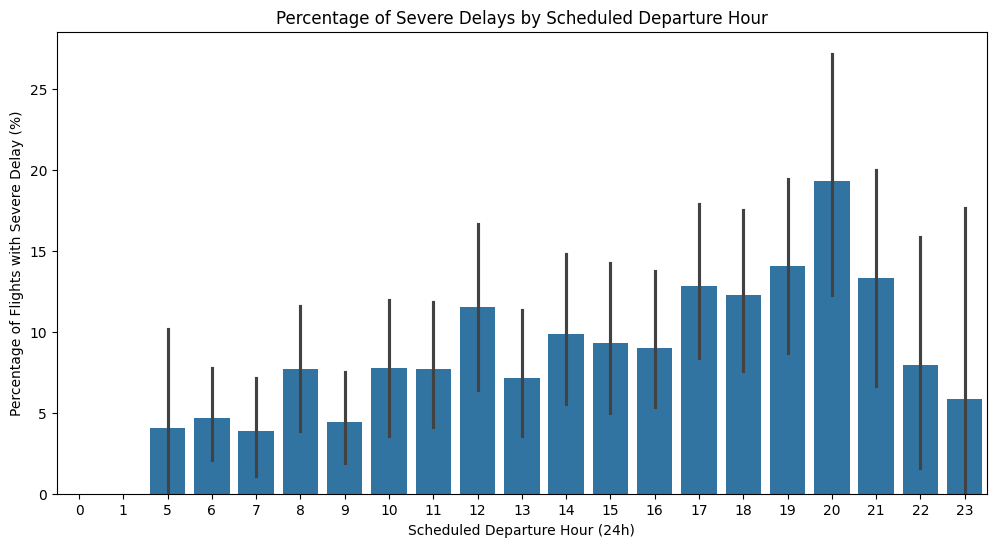

In [43]:
# 2. Barchart of delays by departure hour

plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_HOUR', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title('Percentage of Severe Delays by Scheduled Departure Hour')
plt.xlabel('Scheduled Departure Hour (24h)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

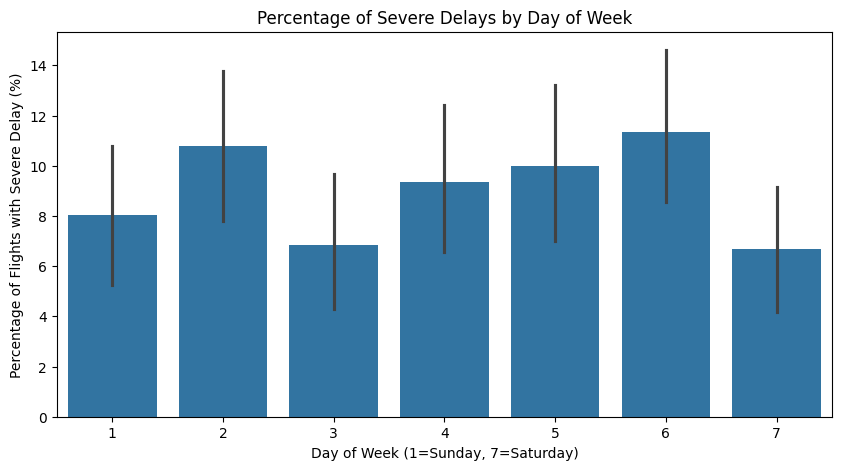

In [44]:
# 3. Delays by Day of the Week

plt.figure(figsize=(10, 5))
sns.barplot(x='DEP_DAY_OF_WEEK', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title(f'Percentage of Severe Delays by Day of Week')
plt.xlabel('Day of Week (1=Sunday, 7=Saturday)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

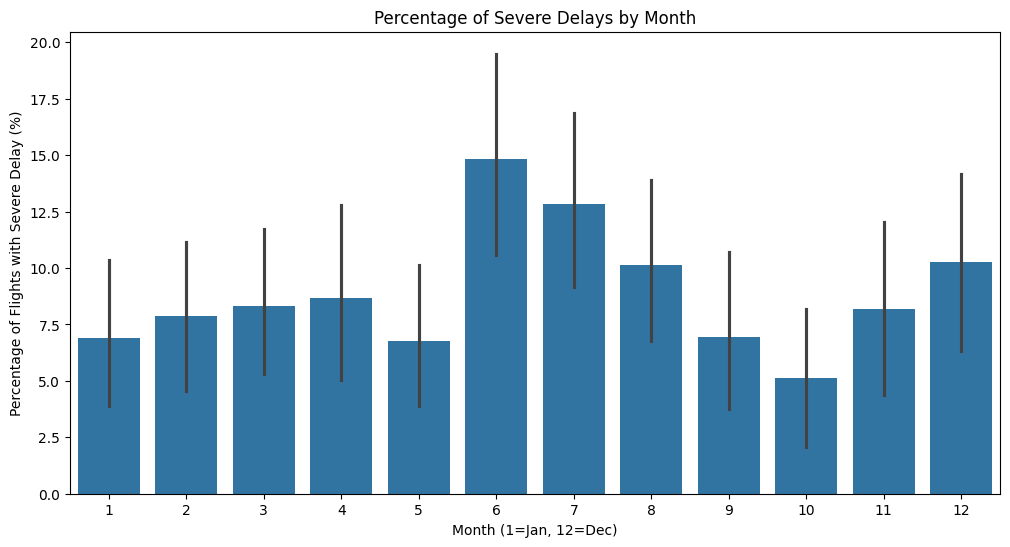

In [45]:
# 4. Delays by Month

plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_MONTH', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title(f'Percentage of Severe Delays by Month')
plt.xlabel('Month (1=Jan, 12=Dec)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

Text(0, 0.5, 'Percentage of Flights with Severe Delay (%)')

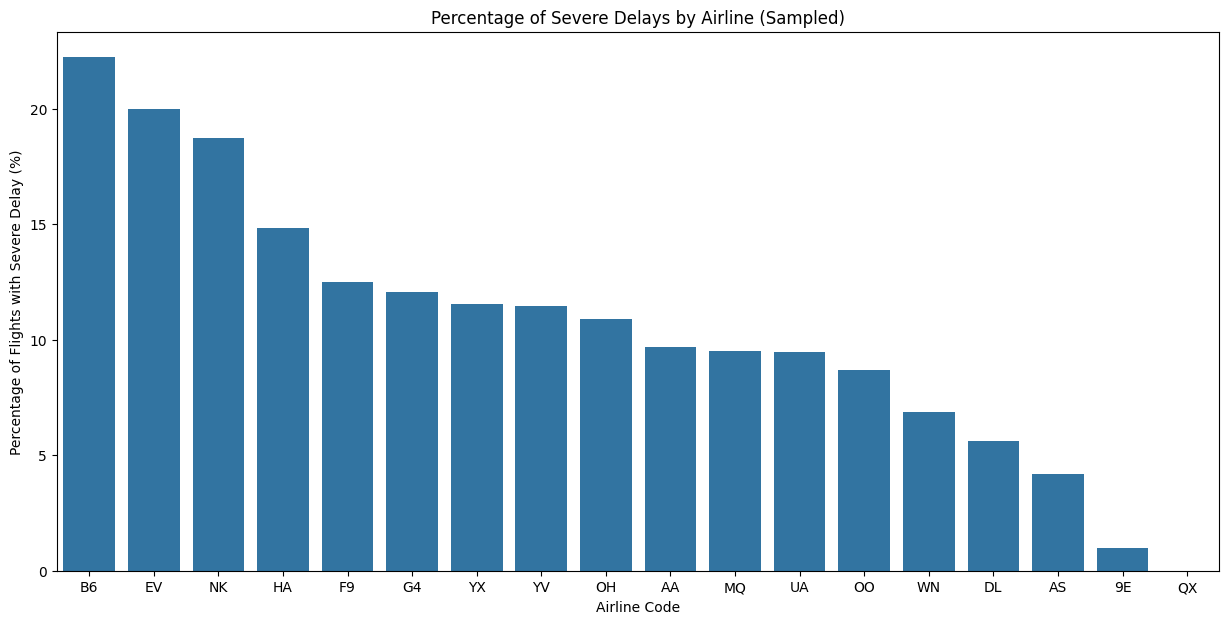

In [46]:
# 5. Top Airlines by Severe Delay Rate (using sampled data)

airline_delay_rate = plot_sample_df.groupby('AIRLINE_CODE')['SEVERE_DELAY'].mean().sort_values(ascending=False) * 100
plt.figure(figsize=(15, 7))
sns.barplot(x=airline_delay_rate.index, y=airline_delay_rate.values)
plt.title('Percentage of Severe Delays by Airline (Sampled)')
plt.xlabel('Airline Code')
plt.ylabel('Percentage of Flights with Severe Delay (%)')

Text(0.5, 0, 'Distance (miles)')

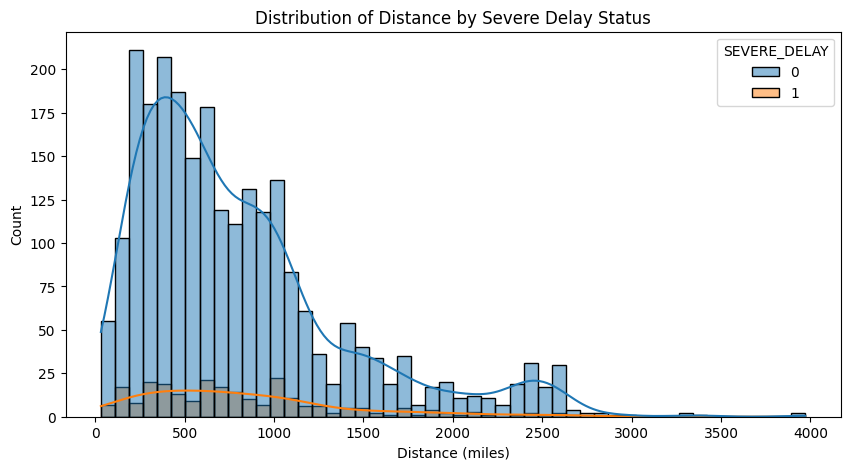

In [47]:
# 6. Numerical Feature Distributions

plt.figure(figsize=(10, 5))
sns.histplot(data=plot_sample_df, x='DISTANCE', hue='SEVERE_DELAY', kde=True, bins=50)
plt.title('Distribution of Distance by Severe Delay Status')
plt.xlabel('Distance (miles)')

# 5. Creating Pipeline

In [48]:
categorical_cols = ["AIRLINE_CODE", "ORIGIN", "DEST"]
numerical_cols = [col for col in featureCols if col not in categorical_cols]

indexers = [
    StringIndexer(inputCol = col, outputCol = col+'Index', handleInvalid = "keep")
    for col in categorical_cols
]

encoders = [
    OneHotEncoder(inputCol= col+'Index', outputCol = col+'OHE')
    for col in categorical_cols
]


In [49]:
num_vector_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="NumFeatures"
)

scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True, withMean=True)

ohe_cols = [col+'OHE' for col in categorical_cols]
final_assembler_inputs = ohe_cols + ["ScaledNumFeatures"]

final_vector_assembler = VectorAssembler(
    inputCols=final_assembler_inputs,
    outputCol="features"
)

In [50]:
pipeline = Pipeline(stages = indexers + encoders + [num_vector_assembler, scaler, final_vector_assembler])
pipeline_model = pipeline.fit(final_df)
processed_df = pipeline_model.transform(final_df)

### Show Results

In [51]:
processed_df.printSchema()

root
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DEP_HOUR: integer (nullable = true)
 |-- DEP_MINUTE: integer (nullable = true)
 |-- ARR_HOUR: integer (nullable = true)
 |-- ARR_MINUTE: integer (nullable = true)
 |-- DEP_DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_MONTH: integer (nullable = true)
 |-- DEP_DAY_OF_MONTH: integer (nullable = true)
 |-- DEP_WEEK_OF_YEAR: integer (nullable = true)
 |-- IS_WEEKEND: integer (nullable = false)
 |-- DISTANCE_PER_MINUTE: double (nullable = true)
 |-- SEVERE_DELAY: integer (nullable = false)
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE_CODEIndex: double (nullable = false)
 |-- ORIGINIndex: double (nullable = false)
 |-- DESTIndex: double (nullable = false)
 |-- AIRLINE_CODEOHE: vector (nullable = true)
 |-- ORIGINOHE: vector (nullable = true)
 |-- DESTOHE: vector (nullable 

In [52]:
# (TO DO): clean up formatting of output
processed_df.select("features", labelCol).show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                                                                                                                                                                |SEVERE_DELAY|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|(784,[4,40,414,

# 6. Training Random Forest Model

In [53]:
model_data = processed_df.select("features", labelCol).withColumnRenamed(labelCol, "label")
train_df, test_df = model_data.randomSplit([0.8, 0.2], seed=101)

# Sampling half the data because it broke it otherwise
train_df_sampled = train_df.sample(withReplacement=False, fraction=0.5, seed=101)
print(f"Using {train_df_sampled.count()} samples for training after extra sampling.")

[Stage 20:>                                                         (0 + 4) / 4]

Using 103488 samples for training after extra sampling.


In [54]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label",
                            numTrees=100,
                            maxDepth=10,
                            seed=101)

rf_model = rf.fit(train_df_sampled)

25/04/18 23:12:08 WARN DAGScheduler: Broadcasting large task binary with size 1284.1 KiB
25/04/18 23:12:15 WARN DAGScheduler: Broadcasting large task binary with size 1688.3 KiB
25/04/18 23:12:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/04/18 23:12:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
                                                                                

In [55]:
predictions = rf_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"\nTest Set Area Under ROC (AUC): {auc:.4f}")

25/04/18 23:12:46 WARN DAGScheduler: Broadcasting large task binary with size 1380.5 KiB
                                                                                


Test Set Area Under ROC (AUC): 0.6409


In [56]:
evaluator_multi = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

accuracy = evaluator_multi.setMetricName("accuracy").evaluate(predictions)
# we are using the weighted metrics because of the imbalance in the data
precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator_multi.setMetricName("weightedRecall").evaluate(predictions)
f1 = evaluator_multi.setMetricName("f1").evaluate(predictions)

print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"Test Set Weighted Precision: {precision:.4f}")
print(f"Test Set Weighted Recall: {recall:.4f}")
print(f"Test Set F1 Score: {f1:.4f}")

25/04/18 23:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1392.8 KiB
25/04/18 23:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1392.8 KiB
25/04/18 23:13:09 WARN DAGScheduler: Broadcasting large task binary with size 1392.8 KiB
25/04/18 23:13:16 WARN DAGScheduler: Broadcasting large task binary with size 1392.8 KiB
[Stage 67:=============================>                            (2 + 2) / 4]

Test Set Accuracy: 0.9196
Test Set Weighted Precision: 0.8456
Test Set Weighted Recall: 0.9196
Test Set F1 Score: 0.8810


/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/04/18 23:13:23 WARN DAGScheduler: Broadcasting large task binary with size 1380.9 KiB
25/04/18 23:13:27 WARN DAGScheduler: Broadcasting large task binary with size 1392.5 KiB
                                                                                


Confusion Matrix:
[[47653.     0.]
 [ 4169.     0.]]


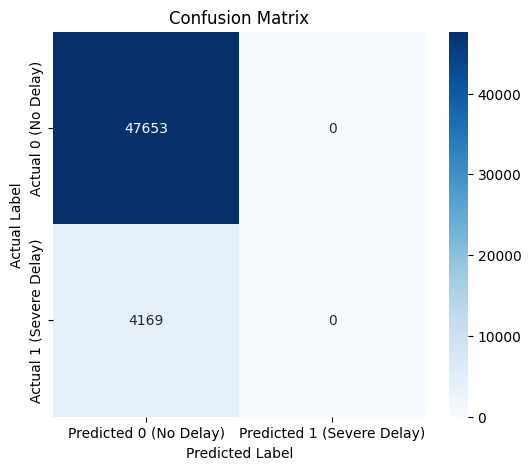

In [57]:
preds_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))
metrics = MulticlassMetrics(preds_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

print("\nConfusion Matrix:")
print(confusion_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Predicted 0 (No Delay)", "Predicted 1 (Severe Delay)"],
            yticklabels=["Actual 0 (No Delay)", "Actual 1 (Severe Delay)"])
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

In [58]:
pipeline_path = "./flight_delay_pipeline_model"
model_path = "./flight_delay_rf_model"

print(f"\nSaving preprocessing pipeline model to: {pipeline_path}")
pipeline_model.write().overwrite().save(pipeline_path)
print("Pipeline model saved.")

print(f"\nSaving RandomForest model to: {model_path}")
rf_model.write().overwrite().save(model_path)
print("RandomForest model saved.")

spark.stop()
print("\nSpark Session Stopped.")


Saving preprocessing pipeline model to: ./flight_delay_pipeline_model
Pipeline model saved.

Saving RandomForest model to: ./flight_delay_rf_model
RandomForest model saved.

Spark Session Stopped.
